In [1]:
# Colab has two versions of TensorFlow installed: a 1.x version and a 2.x version. 
# Colab currently uses TF 1.x by default
# To enable TF2 execute the following code

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


2.2.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/data.h5.zip

'/content/gdrive/My Drive/Colab Notebooks/data.h5.zip'


In [4]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/data.h5.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/data.h5.zip
  inflating: data1.h5                


### Loading the Train and the Test Data 

In [5]:
import numpy as np
import h5py


def loadDataH5():
        

    with h5py.File('data1.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

X_train, y_train, X_test, y_test = loadDataH5()

print('Shape of the feature training data: \n', X_train.shape)
print('Shape of the true training class labels: \n', y_train.shape)
print()
print('Shape of the feature test data: \n', X_test.shape)
print('Shape of the true test class labels: \n', y_test.shape)

(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)
Shape of the feature training data: 
 (1020, 128, 128, 3)
Shape of the true training class labels: 
 (1020,)

Shape of the feature test data: 
 (340, 128, 128, 3)
Shape of the true test class labels: 
 (340,)


In [0]:
import warnings # Ignoring unnecessory warnings
warnings.filterwarnings("ignore")  
# Importing the necessary libraries 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import matplotlib.pyplot as plt

## Feature Extraction in Transfer Learning 


### Some important functions

In [0]:
def get_pretrained_models(configuration):
  """
  Returns the 3 pretrained models from keras with removed fully connected layers  
  """
  # Fetching the VGG16 model and its variant 
  vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))
  vgg16_variant= tf.keras.Model(inputs=vgg16.input,
                                outputs=vgg16.get_layer('block4_conv2').output)
  # Fetching the VGG19 model and its variant 
  vgg19 = tf.keras.applications.VGG19(include_top=False,  input_shape=(128, 128, 3))
  vgg19_variant= tf.keras.Model(inputs=vgg19.input,
                                outputs=vgg19.get_layer('block4_conv4').output)
  # Fetching the Inception 3 model and its variant 
  inception3 = tf.keras.applications.InceptionV3(include_top=False,  input_shape=(128, 128, 3))
  
  if configuration=='initial':
    return vgg16, vgg19, inception3
  elif configuration=='variant':
    return vgg16_variant, vgg19_variant

def get_new_datasets(model, X_train, X_test):
  """
  Returns the new feature training and the new feature test data containing the descriptive features from the pretrained models
  """
  # Push all the training examples into the truncated pre-trained model 
  # It will be a 4-d array 
  features_train= model.predict(X_train)
  # Push all the validation/test examples into the truncated pre-trained model 
  # It will be a 4-d array 
  features_test= model.predict(X_test)

  # Tranform the new training dataset into a 2-d array 
  features_train = features_train.reshape(features_train.shape[0], -1)
  # Tranform the new training dataset into a 2-d array 
  features_test = features_test.reshape(features_test.shape[0], -1)

  return features_train, features_test 

def get_ML_models():
  """
  Build the range of ML models
  """
  # Importing the various models 
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.svm import SVC

  # Build these imported ML models 
  random_forest= RandomForestClassifier(max_depth=2, random_state=0)
  logistic_regression = LogisticRegression(random_state=0)
  decision_tree = DecisionTreeClassifier(random_state=0)
  svm = SVC(random_state=0)
  
  return random_forest, logistic_regression, decision_tree, svm

def train_evaluate(random_forest, logistic_regression, decision_tree, svm):
  """
  Train and Evaluate these ML models on the test set 
  """
  from sklearn.metrics import accuracy_score
  model_names= ['Random Forest', 'Logistic Regression', 'Decision Tree', 'SVM']
  models= [random_forest, logistic_regression, decision_tree, svm]
  for model_name, model in zip(model_names, models):
    trained_model = model.fit(features_train, y_train)
    predictions= trained_model.predict(features_test)
    accuracy = accuracy_score(predictions, y_test)
    print("TEST ACCURACY on {} is:{} ".format(model_name, accuracy))
    print("----------------------------------------------------------------------------------------")
    print("\n")

### Fetching of Pre-trained and Machine Learning Models 

In [0]:
# Get the pretrained models 
vgg16, vgg19, inception3= get_pretrained_models('initial')

# Get the various ML models 
random_forest, logistic_regression, decision_tree, svm= get_ML_models()

### Impact of Feature Extraction from VGG16 with various ML models 

In [0]:
# Get the new feature train and test data from pre-trained VGG16 model 
features_train, features_test = get_new_datasets(vgg16, X_train, X_test)

# Train and Evaluate these ML models on the test set 
train_evaluate(random_forest, logistic_regression, decision_tree, svm)

TEST ACCURACY on Random Forest is:0.611764705882353 
----------------------------------------------------------------------------------------


TEST ACCURACY on Logistic Regression is:0.8794117647058823 
----------------------------------------------------------------------------------------


TEST ACCURACY on Decision Tree is:0.4647058823529412 
----------------------------------------------------------------------------------------


TEST ACCURACY on SVM is:0.8441176470588235 
----------------------------------------------------------------------------------------




### Impact of Feature Extraction from VGG19 with various ML models 

In [0]:
# Get the new feature train and test data from pre-trained VGG16 model 
features_train, features_test = get_new_datasets(vgg19, X_train, X_test)

# Train and Evaluate these ML models on the test set 
train_evaluate(random_forest, logistic_regression, decision_tree, svm)

TEST ACCURACY on Random Forest is:0.6529411764705882 
----------------------------------------------------------------------------------------


TEST ACCURACY on Logistic Regression is:0.8676470588235294 
----------------------------------------------------------------------------------------


TEST ACCURACY on Decision Tree is:0.4470588235294118 
----------------------------------------------------------------------------------------


TEST ACCURACY on SVM is:0.8117647058823529 
----------------------------------------------------------------------------------------




### Impact of Feature Extraction from InceptionV3 with various ML models 

In [0]:
# Get the new feature train and test data from pre-trained VGG16 model 
features_train, features_test = get_new_datasets(inception3, X_train, X_test)

# Train and Evaluate these ML models on the test set 
train_evaluate(random_forest, logistic_regression, decision_tree, svm)

TEST ACCURACY on Random Forest is:0.47352941176470587 
----------------------------------------------------------------------------------------


TEST ACCURACY on Logistic Regression is:0.8470588235294118 
----------------------------------------------------------------------------------------


TEST ACCURACY on Decision Tree is:0.45588235294117646 
----------------------------------------------------------------------------------------


TEST ACCURACY on SVM is:0.8411764705882353 
----------------------------------------------------------------------------------------




### Fetching of Variants of Pre-trained models and ML models 

In [0]:
# Get the pretrained models variants 
vgg16_variant, vgg19_variant= get_pretrained_models('variant')

# Get the various ML models 
random_forest, logistic_regression, decision_tree, svm= get_ML_models()

### Exploring the variants of VGG16 and VGG19  

In [0]:
print("The architecture of VGG16 without fully connected layers")
print(vgg16_variant.summary())
print()
print("The architecture of VGG19 without fully connected layers")
print(vgg19_variant.summary())

The architecture of VGG16 without fully connected layers
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
bl

### Impact of Feature Extraction from variant of VGG16 with various ML models 

In [0]:
# Get the new feature train and test data from pre-trained variant of VGG16 model 
features_train, features_test = get_new_datasets(vgg16_variant, X_train, X_test)

# Train and Evaluate these ML models on the test set 
train_evaluate(random_forest, logistic_regression, decision_tree, svm)

TEST ACCURACY on Random Forest is:0.4852941176470588 
----------------------------------------------------------------------------------------


TEST ACCURACY on Logistic Regression is:0.8294117647058824 
----------------------------------------------------------------------------------------


TEST ACCURACY on Decision Tree is:0.3941176470588235 
----------------------------------------------------------------------------------------


TEST ACCURACY on SVM is:0.788235294117647 
----------------------------------------------------------------------------------------




### Impact of Feature Extraction from Variant of VGG19 with various ML models 

In [0]:
# Get the new feature train and test data from pre-trained variant of VGG19 model 
features_train, features_test = get_new_datasets(vgg19_variant, X_train, X_test)

# Train and Evaluate these ML models on the test set 
train_evaluate(random_forest, logistic_regression, decision_tree, svm)

TEST ACCURACY on Random Forest is:0.4235294117647059 
----------------------------------------------------------------------------------------


TEST ACCURACY on Logistic Regression is:0.7941176470588235 
----------------------------------------------------------------------------------------


TEST ACCURACY on Decision Tree is:0.38235294117647056 
----------------------------------------------------------------------------------------


TEST ACCURACY on SVM is:0.711764705882353 
----------------------------------------------------------------------------------------




## Fine Tuning in Transfer Learning 

### Some Important Functions 

In [0]:
#------------------------------------- SPECIFYING THE EXECUTION PARAMETERS---------------------------------------------------------

def compile_train_plot(model,optimizer):
  """
  This function compiles and train the model and produce the desired results 
  """
  # Specify the number of epochs 
  NUM_EPOCHS = 30

  # Initialize the optimizer and model
  print("Compiling model...")

  # Set the optimizer 
  if optimizer=='normal':
    opt = tf.keras.optimizers.SGD(lr=0.01)
  elif optimizer=='small':
    opt= opt= tf.keras.optimizers.RMSprop(lr=1e-5)
  
  # Print the model settings 
  print (model.summary())

  # Compile the model 
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#-------------------------------------- CODE FOR TRAINING THE MODEL--------------------------------------------------------

  # Train the network
  print("Training network...")
  history= model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=NUM_EPOCHS)

#-----------------------CODE FOR PLOTTING THE TRAINING LOSS AND ACCURACY & VALIDATION LOSS AND ACCURACY-------------------------- 

  plt.style.use("ggplot")
  plt.figure()

  upper_limit= NUM_EPOCHS
  plt.plot(np.arange(0, upper_limit), history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, upper_limit), history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, upper_limit), history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, upper_limit), history.history["val_accuracy"], label="val_acc")
  plt.title("Number of Epochs vs Training/Validation Loss and Accuracy")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
#------------------------------ TEST SET RESULTS-------------------------------------------------

  # Get the predictions from our basic model 
  results= model.evaluate(X_test, y_test)
  # Print the test set loss and the accuracy 
  print("The test set loss and accuracy is \n",results)

def phase1_model():
  """
  Replace the fully connected layers with your own FC layers
  """
  # Fetching the VGG16 model with fully connected layers
  vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
  # Freeze the weights of all the layers in the network 
  vgg16.trainable= False
  # Create a new model 
  model= tf.keras.models.Sequential()
  # Add the freezed vgg16 model to our new model 
  # By default the weights associated with the addition of new layers will be updated in the training process. 
  model.add(vgg16)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(500, activation='relu'))
  model.add(tf.keras.layers.Dense(150, activation='relu'))
  model.add(tf.keras.layers.Dense(17, activation='softmax'))

  return model

def phase2_model(vgg_model, unfreeze_point):
  """
  Unfreeze some of the trainable weights in VGG16 model layers 
  """
  vgg_model.trainable = True
  trainable_flag = False

  # Unfreeze all the layers after given layer (block4_conv1)
  for layer in vgg_model.layers:
    if layer.name ==unfreeze_point:
      trainable_flag = True
    layer.trainable = trainable_flag

  model= tf.keras.models.Sequential()
  model.add(vgg_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(500, activation='relu'))
  model.add(tf.keras.layers.Dense(150, activation='relu'))
  model.add(tf.keras.layers.Dense(17, activation='softmax'))

  return model 

### Results of Phase 1 of Fine tuning 

Compiling model...
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_24 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_69 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_70 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 4,174,217
Non-trainable params: 14,714,688
______________

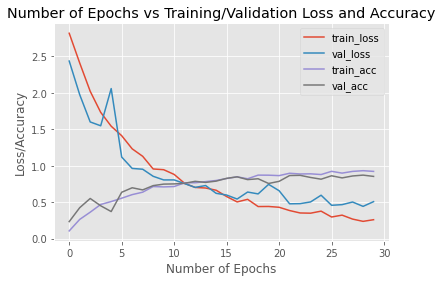

11/11 [==============================] - 1s 58ms/step - loss: 0.5065 - accuracy: 0.8529
The test set loss and accuracy is 
 [0.5065008997917175, 0.8529411554336548]


In [0]:
# Get the model from phase 1 
model_phase1= phase1_model()

# Train the model and specify the optimizer to be normal
compile_train_plot(model_phase1, 'normal')

### Results of Phase 2 Fine Tuning with different configurations settings

Compiling model...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_60 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_61 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 17,153,417
Non-trainable params: 1,735,488
______________

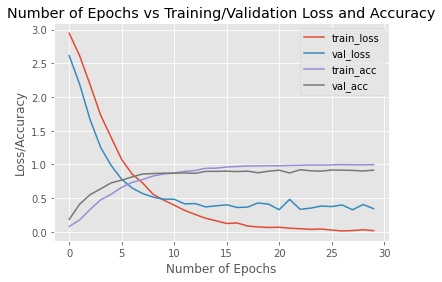

11/11 [==============================] - 1s 58ms/step - loss: 0.3448 - accuracy: 0.9147
The test set loss and accuracy is 
 [0.3447767496109009, 0.9147058725357056]


In [0]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))

# Set the unfreeze point in the VGG16 model 
unfreeze_point= 'block4_conv1'
# Get the model from phase 2
model_phase2= phase2_model(vgg16, unfreeze_point)

# Train the model and specify the optimizer to be small 
compile_train_plot(model_phase2, 'small')

Compiling model...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_25 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_72 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_73 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 11,253,641
Non-trainable params: 7,635,264
______________

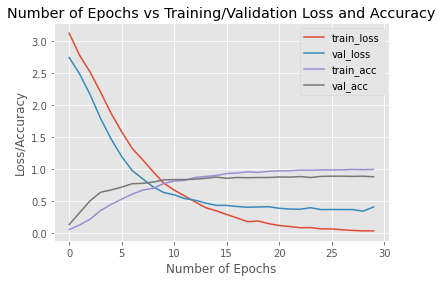

11/11 [==============================] - 1s 58ms/step - loss: 0.4074 - accuracy: 0.8794
The test set loss and accuracy is 
 [0.40743955969810486, 0.8794117569923401]


In [0]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))

# Set the unfreeze point in the VGG16 model 
unfreeze_point= 'block5_conv1'
# Get the model from phase 2
model_phase2= phase2_model(vgg16, unfreeze_point)

# Train the model and specify the optimizer to be small 
compile_train_plot(model_phase2, 'small')

Compiling model...
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_75 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_76 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 18,628,745
Non-trainable params: 260,160
________________

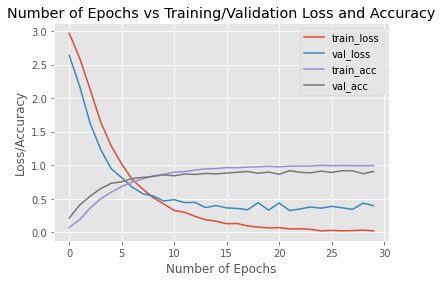

11/11 [==============================] - 1s 59ms/step - loss: 0.3968 - accuracy: 0.9059
The test set loss and accuracy is 
 [0.3967837691307068, 0.9058823585510254]


In [0]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))

# Set the unfreeze point in the VGG16 model 
unfreeze_point= 'block3_conv1'
# Get the model from phase 2
model_phase2= phase2_model(vgg16, unfreeze_point)

# Train the model and specify the optimizer to be small 
compile_train_plot(model_phase2, 'small')

### Application of Data Augmentation technique on Configuration setting 1(came out to be best from above) 

In [0]:
def get_generator_objects():
  """
  This function returns the generator objects for training and validation data 
  """
  # ---------------------- DATA AUGMENTATION CONFIGURATION 1------------------------------------

  train_data_generator1 = tf.keras.preprocessing.image.ImageDataGenerator(
      zoom_range=-0.2,
      shear_range=0.2,
      vertical_flip=False,
      rotation_range=30,
      horizontal_flip=True)
  
  # ---------------------- DATA AUGMENTATION CONFIGURATION 2------------------------------------

  train_data_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(
      zoom_range=-0.2,
      shear_range=0.2,
      vertical_flip=True,
      rotation_range=30,
      horizontal_flip=False,
      height_shift_range=0.1,
      width_shift_range=0.1)
  
  validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1.0/255)
    
  train_generator1 = train_data_generator1.flow(X_train, y_train)
  train_generator2 = train_data_generator2.flow(X_train, y_train)
  validation_generator= validation_data_generator.flow(X_test, y_test)
  
  return train_generator1, train_generator2, validation_generator

def train_with_DA(model, train_generator):
  """
  DA------> Data Augmentation 
  This function compiles and train the model and produce the desired results 
  """
  # Specify the number of epochs 
  NUM_EPOCHS = 60

  # Initialize the optimizer and model
  print("Compiling model...")

  # Set the optimizer 
  opt= tf.keras.optimizers.RMSprop(lr=1e-5)

  # Print the model settings 
  print (model.summary())

  # Compile the model 
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#-------------------------------------- CODE FOR TRAINING THE MODEL--------------------------------------------------------

  # Train the network
  batchSize= 64
  train_steps = X_train.shape[0] // batchSize
  validation_steps = X_test.shape[0] // batchSize

  print("Training network...")
  history= model.fit(train_generator, steps_per_epoch= train_steps,
                     epochs= NUM_EPOCHS,
                     validation_data= (X_test, y_test), validation_steps=validation_steps)

#-----------------------CODE FOR PLOTTING THE TRAINING LOSS AND ACCURACY & VALIDATION LOSS AND ACCURACY-------------------------- 

  plt.style.use("ggplot")
  plt.figure()

  upper_limit= NUM_EPOCHS
  plt.plot(np.arange(0, upper_limit), history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, upper_limit), history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, upper_limit), history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, upper_limit), history.history["val_accuracy"], label="val_acc")
  plt.title("Number of Epochs vs Training/Validation Loss and Accuracy")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
#------------------------------ TEST SET RESULTS-------------------------------------------------

  # Get the predictions from our basic model 
  results= model.evaluate(X_test, y_test)
  # Print the test set loss and the accuracy 
  print("The test set loss and accuracy is \n",results)

### Data Augmentation Configuration 1 with best model obtained 

Compiling model...
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_27 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_82 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_83 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 17,153,417
Non-trainable params: 1,735,488
______________

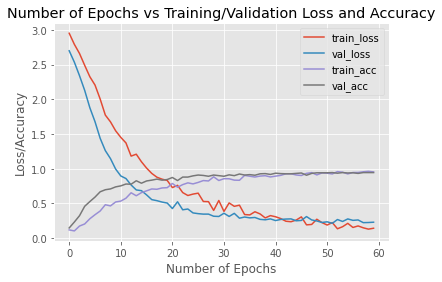

11/11 [==============================] - 0s 26ms/step - loss: 0.2295 - accuracy: 0.9441
The test set loss and accuracy is 
 [0.22952333092689514, 0.9441176652908325]


In [66]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))

# Set the unfreeze point in the VGG16 model 
unfreeze_point= 'block4_conv1'
# Get the model from phase 2
model_phase2= phase2_model(vgg16, unfreeze_point)

# Get the generator objects for training and validation 
train_generator1, train_generator2, validation_generator= get_generator_objects()

# Compile and train the model with data augmentation and produce the plots 
train_with_DA(model_phase2, train_generator1)

### Data Augmentation Configuration 2 on the best model obtained 

Compiling model...
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_28 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_84 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_85 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_86 (Dense)             (None, 17)                2567      
Total params: 18,888,905
Trainable params: 17,153,417
Non-trainable params: 1,735,488
______________

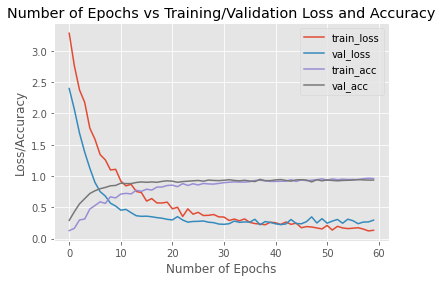

11/11 [==============================] - 0s 26ms/step - loss: 0.2951 - accuracy: 0.9353
The test set loss and accuracy is 
 [0.2950620651245117, 0.9352940917015076]


In [67]:
# Set the unfreeze point in the VGG16 model 
unfreeze_point= 'block4_conv1'
# Get the model from phase 2
model_phase2= phase2_model(vgg16, unfreeze_point)

# Get the generator objects for training and validation 
train_generator1, train_generator2, validation_generator= get_generator_objects()

# Compile and train the model with data augmentation and produce the plots 
train_with_DA(model_phase2, train_generator2)